## Data pipeline for predicting risk of mortality.

## Imports and Globals

In [1]:
import os
import random
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cyclops.feature_handler import FeatureHandler
from cyclops.plotter import plot_timeline, set_bars_color, setup_plot
from cyclops.processor import run_data_pipeline
from cyclops.processors.aggregate import Aggregator
from cyclops.processors.column_names import (
    ADMIT_TIMESTAMP,
    AGE,
    DIAGNOSIS_CODE,
    DISCHARGE_DISPOSITION,
    DISCHARGE_TIMESTAMP,
    ENCOUNTER_ID,
    EVENT_CATEGORY,
    EVENT_NAME,
    EVENT_TIMESTAMP,
    EVENT_VALUE,
    HOSPITAL_ID,
    LENGTH_OF_STAY_IN_ER,
    RESTRICT_TIMESTAMP,
    SEX,
    TIMESTEP,
    TRIAGE_LEVEL,
    WINDOW_START_TIMESTAMP,
)

from cyclops.processors.constants import SMH
from cyclops.processors.events import (
    combine_events,
    convert_to_events,
    normalize_events,
)
from cyclops.processors.impute import Imputer
from cyclops.processors.statics import compute_statics
from cyclops.processors.util import (
    create_indicator_variables,
    fill_missing_timesteps,
    gather_columns,
    pivot_aggregated_events_to_features,
)
from cyclops.query import gemini
from cyclops.utils.file import load_dataframe, save_dataframe

MORTALITY = "mortality"
LOS = "los"
BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/_extract_v3"
AGGREGATION_WINDOW = 6*24
AGGREGATION_BUCKET_SIZE = 24

2022-06-16 14:22:19,552 INFO cyclops.orm     - Database setup, ready to run queries!


## Run query, save

In [2]:
# os.makedirs(BASE_DATA_PATH, exist_ok=True)
# er_admin_table = gemini.get_table(gemini.ER_ADMIN)
# encounters = gemini.patient_encounters(
#     er_admin_table=er_admin_table,
#     years=[2018, 2019, 2020],
#     died=True,
#     died_binarize_col="mortality",
# )
# encounters_labs = gemini.events(
#     patient_encounters_table=encounters.query, event_category="lab"
# )
# encounters_vitals = gemini.events(
#     patient_encounters_table=encounters.query, event_category="vitals"
# )
# imaging = gemini.imaging(years=[2018, 2019, 2020])
# transfusions = gemini.blood_transfusions(years=[2018, 2019, 2020])
# interventions = gemini.interventions(years=[2018, 2019, 2020])

# encounters.run()
# print(f"{len(encounters.data)} rows extracted!")

# encounters_labs.run()
# print(f"{len(encounters_labs.data)} rows extracted!")
# encounters_labs.save(os.path.join(BASE_DATA_PATH, "labs"))
# encounters_labs.clear_data()

# encounters_vitals.run()
# print(f"{len(encounters_vitals.data)} rows extracted!")
# encounters_vitals.save(os.path.join(BASE_DATA_PATH, "vitals"))
# encounters_vitals.clear_data()

# imaging.run()
# print(f"{len(imaging.data)} rows extracted!")
# transfusions.run()
# print(f"{len(transfusions.data)} rows extracted!")
# interventions.run()
# print(f"{len(interventions.data)} rows extracted!")

# encounters_imaging = pd.merge(
#     encounters.data, imaging.data, on=ENCOUNTER_ID, how="inner"
# )
# encounters_transfusions = pd.merge(
#     encounters.data, transfusions.data, on=ENCOUNTER_ID, how="inner"
# )
# encounters_interventions = pd.merge(
#     encounters.data, interventions.data, on=ENCOUNTER_ID, how="inner"
# )

# encounters.save(os.path.join(BASE_DATA_PATH, "admin_er"))
# encounters_imaging.to_parquet(os.path.join(BASE_DATA_PATH, "imaging.parquet"))
# encounters_transfusions.to_parquet(os.path.join(BASE_DATA_PATH, "transfusions.parquet"))
# encounters_interventions.to_parquet(
#     os.path.join(BASE_DATA_PATH, "interventions.parquet")
# )

## Read saved query data

In [3]:
encounters_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "admin_er.parquet"))
labs_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "labs.parquet"))
# vitals_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "vitals.parquet"))
imaging_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "imaging.parquet"))
transfusions_data = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, "transfusions.parquet")
)
interventions_data = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, "interventions.parquet")
)

## Map imaging and transfusions such that they can be treated as events

In [4]:
imaging_data = imaging_data.rename(
    columns={
        "imaging_test_description": EVENT_NAME,
        "performed_date_time": EVENT_TIMESTAMP,
    }
)
imaging_data[EVENT_CATEGORY] = "imaging"
imaging_data[EVENT_VALUE] = 1
#imaging_data

In [5]:
transfusions_data = transfusions_data.rename(
    columns={"issue_date_time": EVENT_TIMESTAMP}
)
transfusions_data[EVENT_NAME] = transfusions_data["rbc_mapped"]
transfusions_data[EVENT_NAME] = transfusions_data[EVENT_NAME].apply(
    lambda x: "rbc" if x else "non-rbc"
)
transfusions_data[EVENT_VALUE] = 1
transfusions_data[EVENT_CATEGORY] = "transfusions"
#transfusions_data

##  Process interventions such that they can be treated as events

In [6]:
interventions_data[EVENT_VALUE] = 1
interventions_data[EVENT_CATEGORY] = "interventions"

binary_mapped_cols = [
    "endoscopy_mapped",
    "gi_endoscopy_mapped",
    "bronch_endoscopy_mapped",
    "dialysis_mapped",
    "inv_mech_vent_mapped",
    "surgery_mapped",
]
interventions_data["intervention_episode_start_time"].loc[
    interventions_data["intervention_episode_start_time"].isna()
] = "12:00:00"
interventions_data[EVENT_TIMESTAMP] = pd.to_datetime(
    interventions_data["intervention_episode_start_date"].astype(str)
    + " "
    + interventions_data["intervention_episode_start_time"].astype(str)
)
interventions_data[EVENT_TIMESTAMP] = interventions_data[EVENT_TIMESTAMP].astype(
    "datetime64[ns]"
)
interventions_data["unmapped_intervention"] = ~(
    interventions_data["endoscopy_mapped"]
    | interventions_data["gi_endoscopy_mapped"]
    | interventions_data["bronch_endoscopy_mapped"]
    | interventions_data["dialysis_mapped"]
    | interventions_data["inv_mech_vent_mapped"]
    | interventions_data["surgery_mapped"]
)
interventions_data[EVENT_NAME] = interventions_data[
    binary_mapped_cols + ["unmapped_intervention"]
].idxmax(axis=1)
#interventions_data

/tmp/ipykernel_388224/1764707256.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions_data["intervention_episode_start_time"].loc[


## Filter out encounters that had less than 24 hours LOS

In [7]:
encounters_data[LOS] = (
    encounters_data[DISCHARGE_TIMESTAMP]
    - encounters_data[ADMIT_TIMESTAMP]
    + pd.to_timedelta(encounters_data[LENGTH_OF_STAY_IN_ER], unit="h")
)
encounters_data_atleast_los_24_hrs = encounters_data.loc[
    encounters_data[LOS] >= pd.to_timedelta(24, unit="h")
]

## Get encounters that ended in mortality outcome

In [8]:
encounters_mortality = encounters_data_atleast_los_24_hrs.loc[
    encounters_data_atleast_los_24_hrs[MORTALITY] == True
]

## Get encounters that didn't end up in mortality outcome (limit to a subset)

In [9]:
encounters_not_mortality = encounters_data_atleast_los_24_hrs.loc[
    encounters_data_atleast_los_24_hrs[MORTALITY] == False
]

num_encounters_not_mortality = len(encounters_mortality)
encounters_not_mortality_subset = encounters_not_mortality[
    0:num_encounters_not_mortality
]
# encounters_not_mortality_subset

## Combine both subsets

In [10]:
encounters_train_val_test = pd.concat(
    [encounters_mortality, encounters_not_mortality_subset], ignore_index=True
)
# encounters_train_val_test

In [ ]:
pd.Timedelta(-offset, unit="h")

Timedelta('-7 days +00:00:00')

## Offset discharge timestamp by K hours and create new column

In [11]:
offset = 7*24  # in hours
encounters_mortality = encounters_mortality.copy()
encounters_mortality["death_timestamp_offset"] = encounters_mortality[
    DISCHARGE_TIMESTAMP
] + pd.Timedelta(-offset, unit="h")
encounters_mortality[[DISCHARGE_TIMESTAMP, "death_timestamp_offset"]]

,discharge_timestamp,death_timestamp_offset
7,2019-08-11 09:21:00,2019-08-04 09:21:00
15,2019-04-27 03:10:00,2019-04-20 03:10:00
36,2019-07-14 08:15:00,2019-07-07 08:15:00
46,2019-08-11 22:47:00,2019-08-04 22:47:00
144,2020-01-10 01:30:00,2020-01-03 01:30:00
...,...,...
90598,2019-10-18 01:24:00,2019-10-11 01:24:00
90614,2018-02-08 18:15:00,2018-02-01 18:15:00
90619,2018-03-17 07:56:00,2018-03-10 07:56:00
90648,2019-12-06 15:30:00,2019-11-29 15:30:00


## Get encounters which result in death within timeframe (i.e. window + offset)

In [12]:
encounters_mortality_within_risk_timeframe = encounters_mortality.loc[
    encounters_mortality[LOS] <= pd.to_timedelta(AGGREGATION_WINDOW + offset, unit="h")
]

## Convert "death_timestamp_offset" to event

In [13]:
mortality_risk_events = convert_to_events(
    encounters_mortality_within_risk_timeframe,
    event_name=f"mortality_risk_{offset}",
    event_category="general",
    timestamp_col="death_timestamp_offset",
)
mortality_risk_events = pd.merge(
    mortality_risk_events, encounters_mortality, on=ENCOUNTER_ID, how="inner"
)
mortality_risk_events = mortality_risk_events[
    [
        ENCOUNTER_ID,
        EVENT_NAME,
        EVENT_TIMESTAMP,
        ADMIT_TIMESTAMP,
        EVENT_VALUE,
        EVENT_CATEGORY,
    ]
]
mortality_risk_events[EVENT_VALUE] = 1
mortality_risk_events

,encounter_id,event_name,event_timestamp,admit_timestamp,event_value,event_category
0,11614557,mortality_risk_168,2019-04-20 03:10:00,2019-04-23 20:13:00,1,general
1,11718178,mortality_risk_168,2019-07-07 08:15:00,2019-07-03 18:42:00,1,general
2,11735654,mortality_risk_168,2019-08-04 22:47:00,2019-08-02 08:52:00,1,general
3,13189407,mortality_risk_168,2018-02-25 10:25:00,2018-02-25 02:00:00,1,general
4,13149700,mortality_risk_168,2019-03-30 03:35:00,2019-03-31 19:53:00,1,general
...,...,...,...,...,...,...
3025,12840487,mortality_risk_168,2020-01-08 03:00:00,2020-01-06 15:16:00,1,general
3026,11322026,mortality_risk_168,2018-12-27 01:22:00,2018-12-28 21:30:00,1,general
3027,11322938,mortality_risk_168,2019-10-11 01:24:00,2019-10-08 03:30:00,1,general
3028,12871095,mortality_risk_168,2018-02-01 18:15:00,2018-02-05 01:19:00,1,general


## Get admission/discharge events

In [62]:
admit_events = convert_to_events(
    encounters_train_val_test,
    event_name="admission",
    event_category="general",
    timestamp_col="admit_timestamp",
)
disch_events = convert_to_events(
    encounters_train_val_test,
    event_name="discharge",
    event_category="general",
    timestamp_col="discharge_timestamp",
)

## Filter labs, vitals, imaging, transfusions, interventions to be in train_val_test subset

In [63]:
labs_train_val_test = labs_data.loc[
    labs_data[ENCOUNTER_ID].isin(encounters_train_val_test[ENCOUNTER_ID])
]
imaging_train_val_test = imaging_data.loc[
    imaging_data[ENCOUNTER_ID].isin(encounters_train_val_test[ENCOUNTER_ID])
]
transfusions_train_val_test = transfusions_data.loc[
    transfusions_data[ENCOUNTER_ID].isin(encounters_train_val_test[ENCOUNTER_ID])
]
interventions_train_val_test = interventions_data.loc[
    interventions_data[ENCOUNTER_ID].isin(encounters_train_val_test[ENCOUNTER_ID])
]

## Normalize all event data

In [64]:
imaging_events = normalize_events(imaging_train_val_test)
transfusion_events = normalize_events(transfusions_train_val_test)
lab_events = normalize_events(labs_train_val_test)
mortality_risk_events = normalize_events(mortality_risk_events)
intervention_events = normalize_events(interventions_train_val_test)
admit_events = normalize_events(admit_events)
disch_events = normalize_events(disch_events)

2022-06-16 14:04:05,374 INFO cyclops.processors.util - Cleaning raw event data...
2022-06-16 14:04:05,378 INFO cyclops.processors.util - # samples: 63860, # encounters: 10131
2022-06-16 14:04:05,380 INFO cyclops.processors.util - # columns: 60, # encounters: 10131
2022-06-16 14:04:05,477 INFO cyclops.processors.util - Remove text in parentheses and normalize event names...
2022-06-16 14:04:05,480 INFO cyclops.processors.util - # samples: 63860, # encounters: 10131
2022-06-16 14:04:05,482 INFO cyclops.processors.util - # columns: 60, # encounters: 10131
2022-06-16 14:04:05,549 INFO cyclops.processors.util - Drop unsupported events...
2022-06-16 14:04:05,552 INFO cyclops.processors.util - # samples: 63860, # encounters: 10131
2022-06-16 14:04:05,554 INFO cyclops.processors.util - # columns: 60, # encounters: 10131
2022-06-16 14:04:05,586 INFO cyclops.processors.util - Normalize event categories...
2022-06-16 14:04:05,590 INFO cyclops.processors.util - # samples: 63860, # encounters: 1013

## Combine different event data, save

In [65]:
combined_events = combine_events(
    [
        intervention_events,
        imaging_events,
        transfusion_events,
        lab_events,
        mortality_risk_events,
        admit_events,
        disch_events,
    ]
)
save_dataframe(combined_events, os.path.join(BASE_DATA_PATH, "combined_events"))

2022-06-16 14:04:55,386 INFO cyclops.utils.file - Saving dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/combined_events.parquet


'/mnt/nfs/project/delirium/drift_exp/_extract_v3/combined_events.parquet'

## Load combined events, aggregate them, save

In [43]:
combined_events = load_dataframe(os.path.join(BASE_DATA_PATH, "combined_events"))

2022-06-16 14:33:14,669 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/combined_events.parquet


## Aggregate combined events, save

In [ ]:
aggregator = Aggregator(bucket_size=AGGREGATION_BUCKET_SIZE, window=AGGREGATION_WINDOW)
aggregated_events = aggregator(combined_events)
save_dataframe(aggregated_events, os.path.join(BASE_DATA_PATH, "aggregated_events"))

## Load aggregated events

In [48]:
aggregated_events = load_dataframe(os.path.join(BASE_DATA_PATH, "aggregated_events"))
aggregated_events

2022-06-16 14:34:38,965 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/aggregated_events.parquet


,encounter_id,timestep,event_value,event_name,count,null_fraction
0,11100375,0,NaN,admission,1,1.0
1,11100375,0,43.50,albumin,2,0.0
2,11100375,1,36.00,albumin,1,0.0
3,11100375,4,40.00,albumin,1,0.0
4,11100375,0,27.70,aptt,1,0.0
...,...,...,...,...,...,...
621303,15999785,5,0.72,troponin,2,0.0
621304,15999785,4,12.00,white blood cell count,1,0.0
621305,15999785,5,12.70,white blood cell count,1,0.0
621306,15999785,4,1.00,x-ray,2,0.0


## Create labels

In [15]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
num_timesteps = int(AGGREGATION_WINDOW / AGGREGATION_BUCKET_SIZE)
encounter_ids = list(encounters_train_val_test[ENCOUNTER_ID])
encounter_ids_idx = np.arange(len(encounter_ids))
num_encounters = len(encounter_ids)
labels = np.zeros((num_encounters, num_timesteps))

labels[
    [
        encounter_ids.index(enc_id)
        for enc_id in list(encounters_mortality_within_risk_timeframe[ENCOUNTER_ID])
    ]
] = 1
print(len(encounters_mortality_within_risk_timeframe))

3030


## Pivot table to get column that can be used to create labels. 1 corresponds to timestep where death happens (shifted by offset)

In [58]:
aggregated_mortality_risk = aggregated_events.loc[
    aggregated_events[EVENT_NAME] == f"mortality_risk_{offset}"
]
missed = set(encounters_mortality_within_risk_timeframe[ENCOUNTER_ID]) - set(
    aggregated_mortality_risk[ENCOUNTER_ID]
)
missed

{12296817, 13651026, 14920341}

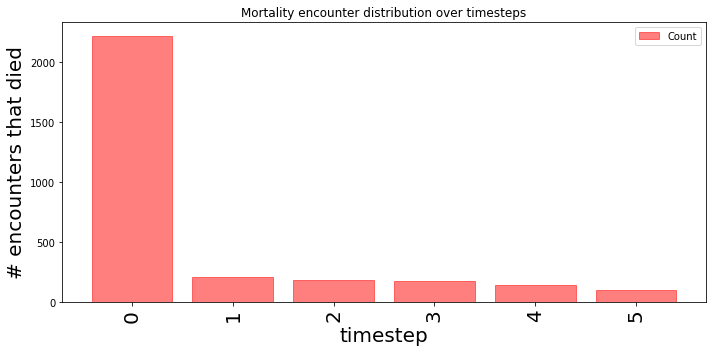

In [25]:
timesteps_mortality_risk = aggregated_mortality_risk["timestep"]
timesteps_mortality_counts = timesteps_mortality_risk.value_counts()
fig, axs = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
ts_vals = plt.bar(
    list(np.unique(timesteps_mortality_risk)), list(timesteps_mortality_counts), alpha=0.5
)
set_bars_color(ts_vals, "r")
axs.set_xticks(
    range(len(ts_vals)),
    list(np.unique(timesteps_mortality_risk)),
    rotation="vertical",
    fontsize=20,
)
setup_plot(
    axs,
    "Mortality encounter distribution over timesteps",
    "timestep",
    "# encounters that died",
    ["Count"],
)
plt.show()

In [26]:
2267 + 3115, len(mortality_risk_events), 2267 + 3030

(5382, 3030, 5297)

## Pivot aggregated events to get column-wise temporal features and save it

In [27]:
temporal_features = pivot_aggregated_events_to_features(aggregated_events, np.mean)
save_dataframe(temporal_features, os.path.join(BASE_DATA_PATH, "temporal_features"))

2022-06-16 14:28:25,182 INFO cyclops.utils.file - Saving dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/temporal_features.parquet


'/mnt/nfs/project/delirium/drift_exp/_extract_v3/temporal_features.parquet'

## Add to feature handler, with indicator variables.

In [28]:
feature_handler = FeatureHandler()

temporal_features = load_dataframe(os.path.join(BASE_DATA_PATH, "temporal_features"))
# indicators = create_indicator_variables(temporal_features)
feature_handler.add_features(temporal_features)
# feature_handler.add_features(indicators)
# feature_handler.drop_features(["death_indicator"])
feature_handler.features["temporal"].columns

2022-06-16 14:28:26,598 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/temporal_features.parquet
2022-06-16 14:28:26,994 WARNING cyclops.feature_handler - Feature admission has all NaNs, will not be added.
2022-06-16 14:28:27,178 WARNING cyclops.feature_handler - Feature discharge has all NaNs, will not be added.
2022-06-16 14:28:27,350 WARNING cyclops.feature_handler - Feature influenza has all NaNs, will not be added.


Index(['albumin', 'aptt', 'arterial paco2', 'arterial pao2', 'arterial ph',
       'bicarbonate', 'bilirubin', 'blood urea nitrogen', 'calcium',
       'calcium, ionized', 'creatinine', 'crp', 'ct', 'dialysis_mapped',
       'echo', 'endoscopy_mapped', 'esr', 'ferritin', 'fibrinogen',
       'glucose fasting', 'glucose point of care', 'glucose random', 'hba1c',
       'hematocrit', 'hemoglobin', 'high sensitivity troponin', 'inr',
       'interventional', 'inv_mech_vent_mapped', 'ketone', 'lactate arterial',
       'lactate venous', 'lipase', 'lymphocyte', 'mean cell volume',
       'mortality_risk_168', 'mri', 'neutrophils', 'non-rbc', 'other',
       'platelet count', 'potassium', 'pt', 'rbc', 'serum alcohol', 'sodium',
       'surgery_mapped', 'troponin', 'ultrasound', 'unmapped_intervention',
       'urine sodium', 'urine specific gravity', 'venous pco2', 'venous ph',
       'vitamin b12', 'vitamin d', 'white blood cell count', 'x-ray'],
      dtype='object')

In [29]:
feature_handler.features["temporal"]["unmapped_intervention"].sum()

5027.0

## Compute static features, save it

In [30]:
encounters_mortality = gather_columns(
    encounters_mortality,
    [
        ENCOUNTER_ID,
        AGE,
        SEX,
        HOSPITAL_ID,
        ADMIT_TIMESTAMP,
        DISCHARGE_TIMESTAMP,
        TRIAGE_LEVEL,
    ],
)
static_features = compute_statics(encounters_mortality)
save_dataframe(static_features, os.path.join(BASE_DATA_PATH, "static_features"))

2022-06-16 14:28:32,328 INFO cyclops.processors.util - Computing static columns...
2022-06-16 14:28:32,330 INFO cyclops.processors.util - # samples: 5297, # encounters: 5297
2022-06-16 14:28:32,331 INFO cyclops.processors.util - # columns: 7, # encounters: 5297
2022-06-16 14:28:37,750 INFO cyclops.processors.statics - Found {'age', 'hospital_id', 'triage_level', 'admit_timestamp', 'sex', 'discharge_timestamp'} static feature columns.
2022-06-16 14:28:37,753 INFO cyclops.utils.profile - Finished executing function infer_statics in 5.421211 s
2022-06-16 14:28:41,901 INFO cyclops.utils.profile - Finished executing function compute_statics in 9.573146 s
2022-06-16 14:28:41,905 INFO cyclops.utils.file - Saving dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/static_features.parquet


'/mnt/nfs/project/delirium/drift_exp/_extract_v3/static_features.parquet'

##  Load static features, add to feature handler, save all features

In [31]:
static_features = load_dataframe(os.path.join(BASE_DATA_PATH, "static_features"))
feature_handler.add_features(
    static_features, reference_cols=[HOSPITAL_ID, ADMIT_TIMESTAMP, DISCHARGE_TIMESTAMP]
)
feature_handler.save(BASE_DATA_PATH, "features")

2022-06-16 14:28:41,933 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/_extract_v3/static_features.parquet
2022-06-16 14:28:41,986 INFO cyclops.feature_handler - Saving static features to /mnt/nfs/project/delirium/drift_exp/_extract_v3/features_static.gzip
2022-06-16 14:28:41,999 INFO cyclops.feature_handler - Saving temporal features to /mnt/nfs/project/delirium/drift_exp/_extract_v3/features_temporal.gzip


## Create new feature handler, load saved features from file

In [32]:
feature_handler1 = FeatureHandler()
feature_handler1.load(BASE_DATA_PATH, "features")

2022-06-16 14:28:42,232 INFO cyclops.feature_handler - Loading features from file...
2022-06-16 14:28:42,234 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-16 14:28:42,236 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-16 14:28:42,260 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-06-16 14:28:43,513 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


## Impute temporal features

In [62]:
def impute_simple(dataframe: pd.DataFrame, time_index: str = TIMESTEP) -> pd.DataFrame:
    """Impute features using 'Simple' method.

    Concatenate the forward filled value, the mask of the measurement,
    and the time of the last measurement.

    Z. Che, S. Purushotham, K. Cho, D. Sontag, and Y. Liu,
    "Recurrent Neural Networks for Multivariate Time Series with Missing Values,"
    Scientific Reports, vol. 8, no. 1, p. 6085, Apr 2018.

    Parameters
    ----------
    dataframe: pandas.DataFrame
        Temporal features dataframe.
    time_index: str, optional
        The name of the time-series index.

    Returns
    -------
    pandas.DataFrame
     Dataframe after applying imputation.

    """
    # Mask missingness.
    masked_df = pd.isna(dataframe)
    masked_df = masked_df.apply(pd.to_numeric)

    # Compute time since last measurement.
    index_of_time = list(dataframe.index.names).index(time_index)
    time_in = [item[index_of_time] for item in dataframe.index.tolist()]
    time_df = dataframe.copy()
    for col in time_df.columns.tolist():
        time_df[col] = time_in
    time_df[masked_df] = np.nan

    # Concatenate the dataframes.
    df_prime = pd.concat(
        [dataframe, masked_df, time_df], axis=1, keys=["measurement", "mask", "time"]
    )
    df_prime.columns = df_prime.columns.rename("impute_simple", level=0)

    # Fill each dataframe using either ffill or mean.
    df_prime = df_prime.fillna(method="ffill").unstack().fillna(0)

    # Swap the levels so that the simple imputation feature is the lowest value.
    col_level_names = list(df_prime.columns.names)
    col_level_names.append(col_level_names.pop(0))

    df_prime = df_prime.reorder_levels(col_level_names, axis=1)
    df_prime.sort_index(axis=1, inplace=True)

    return df_prime


def create_train_test_split(
    encounters: pd.DataFrame,
    fractions: Optional[List] = [0.8, 0.2],
    split_column: Optional[str] = None,
    split_values: List = None,
) -> tuple:
    """Split encounters into train/test.

    Parameters
    ----------
    encounters: pandas.DataFrame
        Dataframe with encounter IDs.
    fractions: list, optional
        Fraction of samples to use for train, test sets.
    split_column: str, optional
        If 'split_column' is specified, then that column is used to split.
    split_values: list, optional
        Along with 'split_column', a list of lists can be specified for filtering.
        e.g. [[2008], [2009, 2010]] for train/test split based on year.

    Returns
    -------
    tuple
        (train IDs, test IDs)

    """
    if split_column:
        if split_column not in encounters.columns:
            raise ValueError("Specified 'split column' not found in input dataframe")
        if not split_values:
            raise ValueError("Specify train/test split values for the 'split column'.!")
        train_encounters = encounters[ENCOUNTER_ID].loc[
            encounters[split_column].isin(split_values[0])
        ]
        test_encounters = encounters[ENCOUNTER_ID].loc[
            encounters[split_column].isin(split_values[1])
        ]
        return train_encounters, test_encounters

    encounter_ids = list(encounters[ENCOUNTER_ID].unique())
    random.shuffle(encounter_ids)
    num_train = int(fractions[0] * len(encounter_ids))

    return encounter_ids[0:num_train], encounter_ids[num_train:]


# By Year
encounters_mortality["year"] = encounters_mortality["admit_timestamp"].dt.year
train_ids, val_test_ids = create_train_test_split(
    encounters_mortality, split_column="year", split_values=[[2018, 2019], [2020]]
)

# By HOSPITAL_ID
# train_ids, val_test_ids = create_train_test_split(encounters_mortality, split_column=HOSPITAL_ID, split_values=[["THPM", "SMH", "THPC", "SBK", "MSH"], ["UHNTW", "UHNTG"]])

# Random
# train_ids, val_test_ids = create_train_test_split(encounters_mortality, split_column=HOSPITAL_ID, split_values=[["THPM", "SMH", "THPC"], ["UHNTW", "UHNTG", "MSH"]])

val_ids, test_ids = create_train_test_split(
    encounters_mortality.loc[encounters_mortality[ENCOUNTER_ID].isin(val_test_ids)],
    [0.5, 0.5],
)
print(
    f"Train set: {len(train_ids)}, Val set: {len(val_ids)}, Test set: {len(test_ids)}"
)
encounters_mortality[HOSPITAL_ID].value_counts(), encounters_mortality[
    "year"
].value_counts()

static = feature_handler1.features["static"]
temporal = feature_handler1.features["temporal"]

mortality_risk_24_targets = temporal["mortality_risk_168"].copy()
temporal = temporal.drop(columns="mortality_risk_168")

X = temporal[
    np.in1d(temporal.index.get_level_values(0), static.index.get_level_values(0))
]
y = mortality_risk_24_targets[
    np.in1d(
        mortality_risk_24_targets.index.get_level_values(0), X.index.get_level_values(0)
    )
]

y_train, y_val, y_test = [
    y[np.in1d(y.index.get_level_values(0), ids)]
    for ids in [train_ids, val_ids, test_ids]
]
X_train, X_val, X_test = [
    X[np.in1d(X.index.get_level_values(0), ids)]
    for ids in [train_ids, val_ids, test_ids]
]

len(X), len(X_train), len(X_val), len(X_test), len(y), len(y_train), len(y_val), len(
    y_test
)

X_train_inputs = impute_simple(X_train)
y_train.head(n=50)
#X_train_inputs = format_dataset(X_train, level="features",imputation_method="simple")
#X_val = X[np.in1d(X.index.get_level_values(0), y_val.index.get_level_values(0))]
#X_val_inputs = format_dataset(X_val, level="features",imputation_method="simple")
#X_test = X[np.in1d(X.index.get_level_values(0), y_test.index.get_level_values(0))]
#X_test_inputs = format_dataset(X_test, level="features",imputation_method="simple")

Train set: 4322, Val set: 487, Test set: 488


encounter_id  timestep
11100856      0           1.0
              1           NaN
              2           NaN
              3           NaN
              4           NaN
              5           NaN
              6           NaN
11103117      0           NaN
              1           NaN
              2           NaN
              3           NaN
              4           NaN
              5           NaN
              6           NaN
11108891      0           NaN
              1           NaN
              2           NaN
              3           NaN
              4           1.0
              5           NaN
              6           NaN
11110408      0           NaN
              1           NaN
              2           NaN
              3           NaN
              4           1.0
              5           NaN
              6           NaN
11111297      0           NaN
              1           1.0
              2           NaN
              3           NaN
              4  

In [ ]:
encounter_id = random.choice(temporal.index.get_level_values(0))
X_train_inputs.loc[encounter_id]["white blood cell count"]

In [49]:
encounter_id = random.choice(aggregated_mortality_risk["encounter_id"].unique())
encounter_id = 15576154

# {12296817, 13651026, 14920341, 15576154}

print(encounter_id)
combined_events_encounter = combined_events.loc[
    combined_events["encounter_id"] == encounter_id
]
fig = plot_timeline(combined_events_encounter, return_fig=True)

fig = fig.update_layout(width=2000, height=800)

aggregator.meta["timestep_end_timestamp"] = (
    aggregator.meta["timestep_start_timestamp"]
    + pd.to_timedelta(AGGREGATION_BUCKET_SIZE, unit="h")
).rename(columns={"timestep_start_timestamp": "timestep_end_timestamp"})
aggregator.meta["timestep_end_timestamp"]
ts_ends = aggregator.meta["timestep_end_timestamp"].loc[encounter_id][
    "timestep_end_timestamp"
]
for ts_end in ts_ends:
    fig.add_vline(ts_end)
fig.show()

# combined_events

15576154


KeyError: 'timestep_start_timestamp'

In [47]:
combined_events.loc[combined_events[ENCOUNTER_ID] == 15576154][EVENT_TIMESTAMP]
# encounters_mortality.loc[encounters_mortality[ENCOUNTER_ID] == 15576154]

6537      2018-06-16 12:23:00
56620     2018-06-09 19:57:00
56621     2018-06-10 07:26:00
56622     2018-06-10 21:09:00
56623     2018-06-11 07:30:00
                  ...        
1702319   2018-06-09 22:40:00
1702320   2018-06-15 07:00:00
1813483   2018-06-10 16:32:00
1816646   2018-06-09 20:13:00
1827240   2018-06-17 16:32:00
Name: event_timestamp, Length: 449, dtype: datetime64[ns]